In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pip install eofs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100375 sha256=52e50ea4e9579a125f6ef64b33dcc41184ccd4268dffc0c5e1aa0aadfee3c953
  Stored in directory: /root/.cache/pip/wheels/5e/0f/2a/805605311a0e20b6d49064f4becdd6889235fdb6ea7266f7db
Successfully built eofs


In [3]:
pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.9/372.9 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 KB 12.9 MB/s eta 0:00:00


In [4]:
pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 79.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.3 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113682 sha256=2aee4e3e94e9055490f06ed1bc4f4e389fa02d873f33ca539c2c801f6a8af6d4
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy


In [5]:
pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# iske bina cartopy crash karega 
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 KB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801328cba85cf6ace157da31a4007bca85e4/shapely-2.0.1.tar.gz#sha256=66a6b1a3e72ece97fc85536a281476f9b7794de2e646ca8a4517e2e3c1446893 (from https://pypi.org/simple/shapely/) (requires-python:>=3.7): Requested unknown from https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801328cba85cf6ace157da31a4007bca85e4/shapely-2.0.1.tar.gz#sha256=66a6b1a3e72ece97fc85536a281476f9b7794de2e646ca8a4517e

In [7]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

In [8]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [9]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
# data_path = './data/train_val/'
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """
        
    # Create training and testing arrays
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time',coords='minimal')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)
#     print(bc_pcs.to_dataframe())
    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)


def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """
        
    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")
        
    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = so2_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [10]:
#Prepare data
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [11]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [12]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [13]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [14]:

# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

In [15]:
#Prepare model
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [16]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [ ]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3319174.4082794595
        x: [ 9.909e+00  9.470e+00 ... -2.530e+00  4.995e-01]
      nit: 615
      jac: [ 9.944e+00  1.572e+00 ... -1.427e+01 -1.277e+01]
     nfev: 709
     njev: 709
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

In [ ]:

#Predict on testing set
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std

In [ ]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.30259081303883945
RMSE at 2100: 0.3516045469425829
RMSE 2045-2055: 0.37169944273566136
RMSE 2090-2100: 0.3947894045205817
RMSE 2050-2100: 0.3880048514010021
RMSE average last 20y: 0.2097947518774863


[Text(0.5, 1.0, 'Difference')]

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


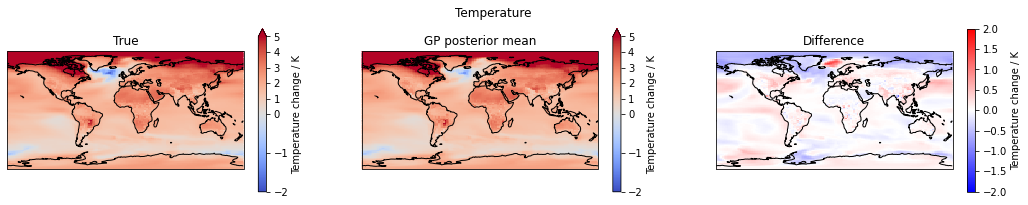

In [ ]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [ ]:

model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.4995]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9.46996
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.90934
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08543
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.77358
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.05499
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.919000e-02, 1.572583e+01, 6.383930e+01..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.31601
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[15.89504, 17.02527, 32.00547..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07666


In [ ]:
# Save predictions
posterior_tas_data.to_netcdf('/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/climatebench-gp-posterior-std-tas-test-2019-2100.nc')